In [2]:
import cmocean as cmo
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xarray as xr

In [3]:
spec_data = xr.open_dataset('../curtain_SSH_spectra_febTS.nc')
spec_data_noSVB = xr.open_dataset('../curtain_SSH_spectra_NoSVB_febTS.nc')
X2 = spec_data.X
freq2 = spec_data.Freq
psd2 = spec_data.psd_data
phase2 = spec_data.phase_data

freq_noSVB = spec_data_noSVB.Freq
psd_noSVB = spec_data_noSVB.psd_data
phase_noSVB = spec_data_noSVB.phase_data

In [4]:
sns.set_style('ticks')
sns.set_context('paper')
cmap=cmo.cm.dense

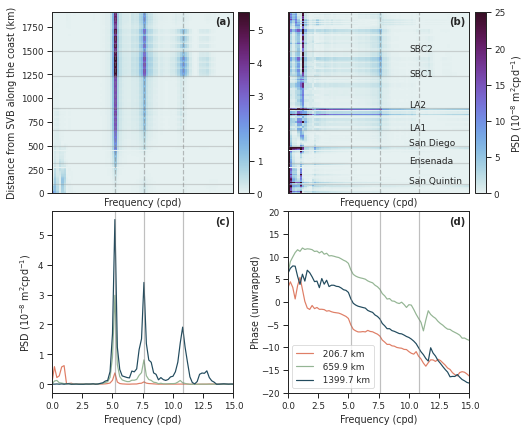

In [9]:
fig = plt.figure(figsize=(7.48,7))
gs = gridspec.GridSpec(2, 1, hspace=0.1)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0],wspace=0.3)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1],wspace=0.3)

ax1 = plt.subplot(gs0[0])
ax2 = plt.subplot(gs0[1])
ax3 = plt.subplot(gs1[0])
ax4 = plt.subplot(gs1[1])


# Bay - no bay
ax1.set_ylabel('Distance from SVB along the coast (km)')
pc1 = ax1.pcolormesh(freq2,X2,1e8*psd2/(1e4*86400), cmap=cmap)
cbar_ax = fig.add_axes([0.47, 0.52, 0.02, 0.36]) 
cb = fig.colorbar(pc1,
                  cax=cbar_ax, orientation='vertical', 
                  format='%1.0f',
                  )

ax1.set_xlim(0,15)

# no bay
pc2 = ax2.pcolormesh(freq_noSVB,X2,1e8*psd_noSVB/(1e4*86400), cmap=cmap,vmin=0, vmax=25)
cbar_ax = fig.add_axes([0.91, 0.52, 0.02, 0.36]) 
cb = fig.colorbar(pc2,
                  cax=cbar_ax, orientation='vertical', 
                  format='%1.0f', label='PSD (10$^{-8}$ m$^2$cpd$^{-1}$)', pad=0,
                  )
ax2.set_xlim(0,15)

colors=[ "#df7e66", "#94b594", "#224b5e","#b75347",]

# Spectra and phase selected stations
for kk, col, lab in zip([100, 307, 440],colors, ['','','']):
    ax3.plot(spec_data.Freq, 1E8*spec_data.psd_data[kk,:]/(1e4*86400),color=col, 
             label='%s %1.1f km' %(lab,X2[kk]))
    ax4.plot(spec_data.Freq, np.unwrap(spec_data.phase_data[kk,:]),
             color=col,label='%s %1.1f km' %(lab,X2[kk]))
ax3.axvline(5.2, color='0.5', alpha=0.5)     
ax4.axvline(5.2, color='0.5', alpha=0.5)     
ax3.axvline(7.6, color='0.5', alpha=0.5)     
ax4.axvline(7.6, color='0.5', alpha=0.5)     
ax3.axvline(10.8, color='0.5', alpha=0.5)     
ax4.axvline(10.8, color='0.5', alpha=0.5)     

ax4.legend(loc='lower left',ncol=1)
ax3.set_xlim(0,15)
ax4.set_ylim(-20,20)
ax4.set_xlim(0,15)
ax3.set_xlabel('Frequency (cpd)')
ax4.set_xlabel('Frequency (cpd)')
ax3.set_ylabel('PSD (10$^{-8}$ m$^2$cpd$^{-1}$)')
ax4.set_ylabel('Phase (unwrapped)', labelpad=0)

# Reference lines
for km, lab in zip([101,313.7,500, 660, 900, 1231, 1492], ['San Quintin','Ensenada','San Diego','LA1','LA2','SBC1', 'SBC2']):
    ax1.axhline(km,color='0.5',alpha=0.3)
    ax2.text(10,km,lab, fontsize=9)
    ax2.axhline(km,color='0.5',alpha=0.3) 
 
# Labels, etc
ax1.set_ylabel('Distance from SVB along the coast (km)')
ax1.set_xticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Frequency (cpd)')
ax2.set_xlabel('Frequency (cpd)')

ax1.text(0.9,0.93,'(a)',fontweight='bold', fontsize=10, transform=ax1.transAxes)
ax2.text(0.89,0.93,'(b)',fontweight='bold', fontsize=10, transform=ax2.transAxes)
ax3.text(0.9,0.93,'(c)',fontweight='bold', fontsize=10, transform=ax3.transAxes)
ax4.text(0.89,0.93,'(d)',fontweight='bold', fontsize=10, transform=ax4.transAxes)

for ax in [ax1,ax2]:
    ax.axvline(5.2, color='0.5', linestyle='--',alpha=0.5)
    ax.axvline(7.6, color='0.5', linestyle='--',alpha=0.5)
    ax.axvline(10.8, color='0.5', linestyle='--',alpha=0.5)


plt.savefig('figure7.png', dpi=500, bbox_inches='tight')
plt.show()